<a href="https://www.kaggle.com/code/hoingcnguynphng/car-price-prediction-with-pyspark?scriptVersionId=260847392" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Car Price Prediction with PySpark
## data-info: Used cars in United States for sale
## data-source: https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data 

# 1. Installation

In [1]:
!pip install pyspark

# 2. Import Necessary Modules

In [2]:
import json

import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
from functools import reduce

from pyspark.sql import SparkSession
from pyspark.sql import types, Window
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, round

from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.clustering import KMeans

# 3. Create a Spark Session

In [3]:
spark = SparkSession.builder.appName('Tutorial').getOrCreate()
spark.sparkContext.setCheckpointDir("/kaggle/working/checkpoints")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/09 09:46:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


# 4. Read the file

In [4]:
file_path = '../input/craigslist-carstrucks-data/vehicles.csv'
df_cars = spark.read.options(header=True, inferSchema=True, delimiter=',', multiLine=True).csv(file_path)

# 5. EDA

In [5]:
df_cars.createOrReplaceTempView('cardata')

25/09/09 09:47:00 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Overview

### Data structure

In [6]:
df_cars.printSchema()

root
 |-- id: long (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: long (nullable = true)
 |-- year: integer (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- VIN: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- posting_date: string (null


The Craigslist Cars dataset contains used car listings in the U.S., collected periodically from Craigslist. Each record represents a listing with details such as price, condition, manufacturer, specifications, and location.

**1. Identifiers & Metadata**

* `id`, `VIN`: Unique IDs for listings/vehicles → keep for tracking, not ML features.
* `url`, `region_url`, `image_url`: Links → useful for reference, not for modeling.
* `region`, `state`, `county`: Geographic info → useful for location-based analysis.
* `lat`, `long`: Precise coordinates → can be engineered into distance features.
* `posting_date`: Date of listing → important for time trend analysis.

**2. Vehicle Information**

* `price`: Target variable for price prediction.
* `year`, `manufacturer`, `model`: Core features affecting car value.
* `odometer`: Mileage → major factor in depreciation.
* `condition`: Car condition (new, good, salvage, …).
* `cylinders`, `fuel`, `transmission`, `drive`: Key technical specs.
* `title_status`: Legal/ownership status → large effect on price.
* `size`, `type`: Segment info (SUV, sedan, compact, …).
* `paint_color`: Minor influence, but may reveal preferences.

**3. Additional Data**

* `description`: Free-text seller notes → usable with NLP.

---

👉 **Most important features for ML/analysis:**  
`price, year, manufacturer, model, odometer, condition, fuel, cylinders, title_status, transmission, drive, size, type, state, lat, long, posting_date`

**Less relevant / auxiliary:**  
`url, region_url, image_url, description`

**Identifiers / sensitive:**  
`id, VIN`

---

In [7]:
df_cars.limit(5).toPandas()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,None,None,None,None,...,None,None,None,None,None,None,az,None,None,None
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,None,None,None,None,...,None,None,None,None,None,None,ar,None,None,None
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,None,None,None,None,...,None,None,None,None,None,None,fl,None,None,None
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,None,None,None,None,...,None,None,None,None,None,None,ma,None,None,None
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,None,None,None,None,...,None,None,None,None,None,None,nc,None,None,None


### Data dictionary

In [8]:
def show_unique_sample(df, exclude=None, limit=20, sample_frac=0.01, seed=42):
    exclude = set(exclude) if exclude else set()
    
    # Resample
    df_sample = df.sample(withReplacement=False, fraction=sample_frac, seed=seed)
    
    for colname in df.columns:
        if colname in exclude:
            continue
        print(f"\n=== {colname}: Unique sample values ===")
        df_sample.select(colname).distinct().show(limit, truncate=False)

show_unique_sample(
    df_cars,
    exclude=["posting_date","id","url","region_url","image_url","description"],
    limit=5,
    sample_frac=0.0005
)


=== region: Unique sample values ===


+---------------+
|region         |
+---------------+
|daytona beach  |
|south jersey   |
|new hampshire  |
|kansas city, MO|
|harrisburg     |
+---------------+
only showing top 5 rows


=== price: Unique sample values ===


+-----+
|price|
+-----+
|13299|
|11495|
|38950|
|0    |
|12881|
+-----+
only showing top 5 rows


=== year: Unique sample values ===


+----+
|year|
+----+
|2003|
|2007|
|2018|
|2015|
|2006|
+----+
only showing top 5 rows


=== manufacturer: Unique sample values ===


+------------+
|manufacturer|
+------------+
|buick       |
|mitsubishi  |
|pontiac     |
|lexus       |
|null        |
+------------+
only showing top 5 rows


=== model: Unique sample values ===


+-----------------+
|model            |
+-----------------+
|charger se       |
|sentra sv        |
|tundra double cab|
|sport die        |
|sentra           |
+-----------------+
only showing top 5 rows


=== condition: Unique sample values ===


+---------+
|condition|
+---------+
|new      |
|null     |
|excellent|
|salvage  |
|like new |
+---------+
only showing top 5 rows


=== cylinders: Unique sample values ===


+------------+
|cylinders   |
+------------+
|null        |
|3 cylinders |
|10 cylinders|
|6 cylinders |
|4 cylinders |
+------------+
only showing top 5 rows


=== fuel: Unique sample values ===


+------+
|fuel  |
+------+
|gas   |
|null  |
|other |
|diesel|
|hybrid|
+------+


=== odometer: Unique sample values ===


+--------+
|odometer|
+--------+
|113000  |
|85000   |
|72785   |
|76000   |
|65203   |
+--------+
only showing top 5 rows


=== title_status: Unique sample values ===


+------------+
|title_status|
+------------+
|null        |
|lien        |
|clean       |
|salvage     |
|rebuilt     |
+------------+


=== transmission: Unique sample values ===


+------------+
|transmission|
+------------+
|null        |
|automatic   |
|other       |
|manual      |
+------------+


=== VIN: Unique sample values ===


+-----------------+
|VIN              |
+-----------------+
|WA1AHAF71JD018521|
|3GNKBCRS6LS625435|
|1FT8W3DT5KEE01850|
|JF1GV7E60EG015091|
|2GKFLTEK4D6315978|
+-----------------+
only showing top 5 rows


=== drive: Unique sample values ===


+-----+
|drive|
+-----+
|null |
|fwd  |
|rwd  |
|4wd  |
+-----+


=== size: Unique sample values ===


+-----------+
|size       |
+-----------+
|compact    |
|null       |
|full-size  |
|mid-size   |
|sub-compact|
+-----------+


=== type: Unique sample values ===


+--------+
|type    |
+--------+
|van     |
|mini-van|
|wagon   |
|null    |
|coupe   |
+--------+
only showing top 5 rows


=== paint_color: Unique sample values ===


+-----------+
|paint_color|
+-----------+
|orange     |
|grey       |
|green      |
|yellow     |
|null       |
+-----------+
only showing top 5 rows


=== county: Unique sample values ===


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|county                                                                                                                                                                                                                                                                                                                                                                                                                                    |
+---------------------------------------------------------------------------------------------------------------------------------------------

+-------------------------------------+
|state                                |
+-------------------------------------+
|ct                                   |
|wy                                   |
|il                                   |
| specializing in our signature lifted|
|tx                                   |
+-------------------------------------+
only showing top 5 rows


=== lat: Unique sample values ===


+---------+
|lat      |
+---------+
|32.891765|
|36.12    |
|37.63981 |
|35.116886|
|42.8561  |
+---------+
only showing top 5 rows


=== long: Unique sample values ===


+-----------+
|long       |
+-----------+
|-105.173998|
|-82.530265 |
|-110.986696|
|-88.06645  |
|-98.396752 |
+-----------+
only showing top 5 rows



### Comments
* "url", "region_url", "image_url", "description" columns are unnecessary. let's drop them
* It seems pyspark interpreted "lat" and "long, "posting_date" columns as string
* We should clean these columns from alphabetic characters
* And we should check the numeric range of "lat" and "long" columns
* Some categorical columns have own null indicators like "other", set them null

In [9]:
cols_to_drop = ["url", "region_url", "image_url", "description"]
df_cars = df_cars.drop(*cols_to_drop)

In [10]:
def clean_string_columns(df, exclude_cols=None, to_lower=True):
    if exclude_cols is None:
        exclude_cols = []

    exprs = []
    for c, t in df.dtypes:
        if t == "string" and c not in exclude_cols:
            col_expr = F.trim(F.col(c))
            if to_lower:
                col_expr = F.lower(col_expr)
            col_expr = F.regexp_replace(col_expr, r'[^a-z0-9]', '_')
            col_expr = F.regexp_replace(col_expr, r'_+', '_')
            col_expr = F.regexp_replace(col_expr, r'^_|_$', '')
            exprs.append(col_expr.alias(c))
        else:
            exprs.append(F.col(c))
    return df.select(*exprs)


def normalize_cars(df):
    df = (
        df
        # numeric cleaning
        .withColumn("price", F.regexp_replace("price", "[^0-9.]", "").cast(types.DoubleType()))
        .withColumn("odometer", F.regexp_replace("odometer", "[^0-9.]", "").cast(types.DoubleType()))
        .withColumn("year", F.regexp_replace("year", "[^0-9]", "").cast(types.IntegerType()))
        # geo validation
        .withColumn("lat", F.when((F.col("lat") >= -90) & (F.col("lat") <= 90), F.col("lat").cast(types.FloatType())))
        .withColumn("long", F.when((F.col("long") >= -180) & (F.col("long") <= 180), F.col("long").cast(types.FloatType())))
        # posting_date validation
        .withColumn(
            "posting_date",
            F.when(
                F.col("posting_date").rlike(r'^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}-\d{4}$'),
                F.col("posting_date")
            ).cast(types.TimestampType())
        )
    )

    # string normalization (exclude id, VIN)
    df = clean_string_columns(df, exclude_cols=["id", "VIN"], to_lower=True)

    # state validation
    df = df.withColumn("state", F.when(F.col("state").rlike("^[a-z]{2}$"), F.col("state")))

    return df

df_cars = normalize_cars(df_cars)

### Missing values

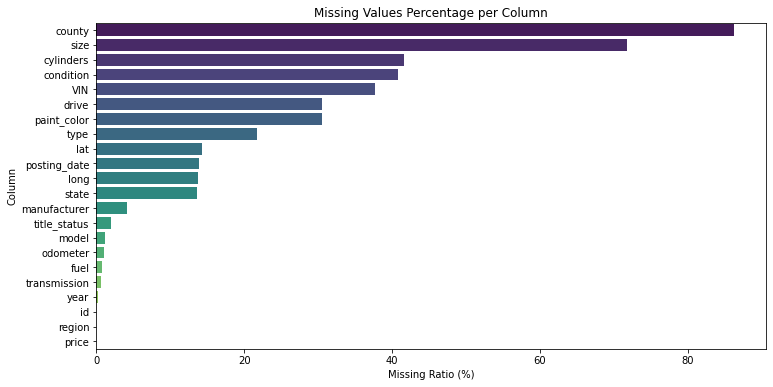

[('county', 367950, 86.2553975554524),
 ('size', 306182, 71.77564923039415),
 ('cylinders', 177571, 41.62646337632624),
 ('condition', 174001, 40.789578556994904),
 ('VIN', 160883, 37.71443708360878),
 ('drive', 130475, 30.586147563657164),
 ('paint_color', 130112, 30.50105255261591),
 ('type', 92787, 21.75126939252008),
 ('lat', 60997, 14.299009334664847),
 ('posting_date', 58973, 13.824540182192404),
 ('long', 58690, 13.758198892592748),
 ('state', 58357, 13.680136527092095),
 ('manufacturer', 17634, 4.133789048764364),
 ('title_status', 8237, 1.9309300439305925),
 ('model', 5272, 1.2358702430013457),
 ('odometer', 4400, 1.0314546792879213),
 ('fuel', 3013, 0.706312033794206),
 ('transmission', 2556, 0.5991814000590743),
 ('year', 1205, 0.28247792921407844),
 ('id', 0, 0.0),
 ('region', 0, 0.0),
 ('price', 0, 0.0)]

In [11]:
def plot_missing_values_spark(df):
    total_rows = df.count()

    # Tạo list expressions đếm null
    agg_exprs = [
        F.count(F.when(F.col(c).isNull(), c)).alias(c)
        for c in df.columns
    ]
    missing_counts = df.agg(*agg_exprs).collect()[0].asDict()

    # Tính ratio
    missing_data = [
        (c, missing_counts[c], missing_counts[c] / total_rows * 100)
        for c in df.columns
    ]
    missing_data.sort(key=lambda x: x[2], reverse=True)

    # Vẽ barplot
    columns, counts, ratios = zip(*missing_data)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(ratios), y=list(columns), palette="viridis")
    plt.title("Missing Values Percentage per Column")
    plt.xlabel("Missing Ratio (%)")
    plt.ylabel("Column")
    plt.show()

    return missing_data

missing_df = plot_missing_values_spark(df_cars)
missing_df

Missing value groups:
* **Very high (>70%)**: `county`, `size` → drop.
* **High (30–70%)**: `cylinders`, `condition`, `VIN`, `drive`, `paint_color` → fill with mode/"unknown" or predict from other columns
* **Moderate (10–30%)**: `type`, `lat`, `long`, `posting_date` → fill with median/mode by group
* **Low (<10%)**: `manufacturer`, `title_status`, `model`, `odometer`, `fuel`, `transmission`, `state`, `year` → fill with mode/median
* **No missing**: `region`, `price`, `id` → keep as is


In [12]:
#Title status has dominant cata -> drop
cols_to_drop = ["county","size", "title_status"]
df_cars = df_cars.drop(*cols_to_drop)

* Filter samples which have null values > 10 (adjust later)

In [13]:
cols_expr = [when(col(c).isNull(), 1).otherwise(0) for c in df_cars.columns]
expr = reduce(lambda a, b: a + b, cols_expr)
df_with_null_count = df_cars.withColumn("null_count", expr)
total_rows = df_cars.count()

df_with_null_count.groupBy("null_count")\
    .count()\
    .withColumn("percent", round(col("count") / total_rows * 100, 2))\
    .orderBy(col("null_count").desc())\
    .show()

+----------+------+-------+
|null_count| count|percent|
+----------+------+-------+
|        15|    68|   0.02|
|        12|    30|   0.01|
|        11|   500|   0.12|
|        10|  2732|   0.64|
|         9|  2735|   0.64|
|         8|  3480|   0.82|
|         7| 10217|    2.4|
|         6| 52424|  12.29|
|         5| 27242|   6.39|
|         4| 28037|   6.57|
|         3| 43790|  10.27|
|         2| 82984|  19.45|
|         1|118512|  27.78|
|         0| 53831|  12.62|
+----------+------+-------+



In [14]:
df_cars = df_with_null_count.filter(col("null_count") < 10).drop("null_count")

### Duplicated values

In [15]:
def check_duplicates(df, cols):
    total = df.count()
    unique = df.select(cols).distinct().count()
    dup_count = total - unique
    dup_ratio = dup_count / total * 100
    
    print(f"Total rows: {total}")
    print(f"Unique rows by {cols}: {unique}")
    print(f"Duplicate rows: {dup_count} ({dup_ratio:.2f}%)")

check_duplicates(df_cars, ["id"])

Total rows: 423252
Unique rows by ['id']: 423252
Duplicate rows: 0 (0.00%)


* Drop duplicates excluding "id" feature

In [16]:
exclude_cols = ["id"]

total_rows = df_cars.count()
distinct_rows = df_cars.drop(*exclude_cols).distinct().count()
duplicates = total_rows - distinct_rows

print("Total rows:", total_rows)
print("Distinct rows (excluding certain columns):", distinct_rows)
print("Duplicated rows:", duplicates)

df_cars = df_cars.dropDuplicates(subset=[c for c in df_cars.columns if c not in exclude_cols])

Total rows: 423252
Distinct rows (excluding certain columns): 414743
Duplicated rows: 8509


## Numeric features

### Descriptive Statistics
#### Hint: If data is too big you can sample it before the descriptive stat calculations

In [17]:
df_cars.select('price', 'year', 'odometer', 'lat', 'long').summary().show()

+-------+--------------------+------------------+------------------+-----------------+------------------+
|summary|               price|              year|          odometer|              lat|              long|
+-------+--------------------+------------------+------------------+-----------------+------------------+
|  count|              414743|            413689|            410504|           365569|            367421|
|   mean|   76513.78471487162|2011.2036288129489| 98193.35131935377|38.26823086253061|-93.06870991646865|
| stddev|1.2357989759373924E7| 9.454706883779652|215124.71267373607|5.772539233372225| 20.45005453410532|
|    min|                 0.0|              1900|               0.0|       -84.122246|        -159.82773|
|    25%|              5900.0|              2008|           37725.0|         34.42675|           -106.62|
|    50%|             13900.0|              2013|           85816.0|          39.0262|            -87.38|
|    75%|             25995.0|              20

**1. `price`**
* Min = `0.0` → invalid (cars can’t be free).
* Max = `3,736,928,711` → extreme outlier, likely data error.
* Very high stddev → heavily right skewed distribution with extreme values.

👉 **Suggested handling**

* Drop `price <= 0` (likely placeholders/test).
* Consider log-transform (`log1p(price)`) to reduce skew for modeling.

---

**2. `year`**

* Min = `1900` → unrealistic (maybe cars weren’t available then).
* Max = `2022` → valid (latest crawl).
* Median ≈ `2013`.
  
👉 **Suggested handling**

* By reading through the wikipedia page of Automotive industry in the United States, It seems that the car sales grew to large numbers during the 1960s, ignore `year < 1960`.
---

**3. `odometer`**
* Min = `0.0` → possible (brand new cars) but may also indicate missing.
* Max = `10,000,000` → unrealistic outlier.
* Mean ≈ `98k` miles → reasonable.
* Right skewed distribution with extreme values.

👉 **Suggested handling**
* Normalize mileage by age (e.g., miles per year).
* Consider log-transform (`log1p(price)`) to reduce skew for modeling.
---

**4. `lat` & `long`**
* `lat = -84` → outside the U.S.
* `long = 173.88` → in Asia, not U.S.
* Mean lat ≈ 38, long ≈ -92 → consistent with U.S. center.

👉 **Suggested handling**
* Keep only U.S. ranges:
  * `lat ∈ [24, 50]`
  * `long ∈ [-125, -65]`
* Set out-of-range records to null or drop them.

In [18]:
def plot_outliers_iqr(df, col):
    # Convert to Pandas
    pdf = df.select(col).dropna().toPandas()
    
    # Compute IQR
    Q1 = pdf[col].quantile(0.25)
    Q3 = pdf[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    print(f"Column: {col}")
    print(f"Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}")
    print(f"Lower bound={lower:.2f}, Upper bound={upper:.2f}")
    print(f"Outliers count={((pdf[col] < lower) | (pdf[col] > upper)).sum()} / {len(pdf)}")
    
    # Plot distribution + boxplot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    sns.histplot(pdf[col], bins=50, kde=True, ax=axes[0])
    axes[0].axvline(lower, color='r', linestyle='--')
    axes[0].axvline(upper, color='r', linestyle='--')
    axes[0].set_title(f"Histogram of {col}")
    
    # Boxplot
    sns.boxplot(x=pdf[col], ax=axes[1])
    axes[1].axvline(lower, color='r', linestyle='--')
    axes[1].axvline(upper, color='r', linestyle='--')
    axes[1].set_title(f"Boxplot of {col}")
    
    plt.show()

#### Price
* Price column still have many outliers arcording to IQR, might remove high-valid value -> Use quantile 0.99 for upper bound, and 0 for lower bound

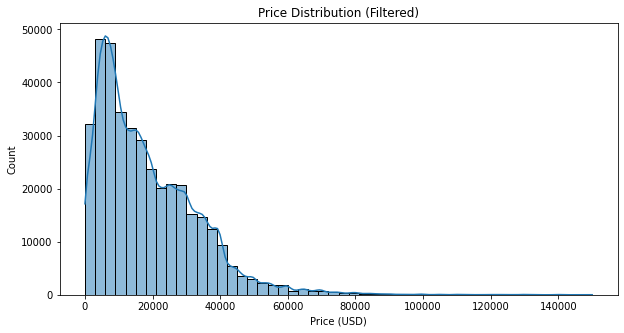

In [19]:
price_df = df_cars.select("price") \
    .where("price > 0 AND price < 150000") \
    .toPandas()

plt.figure(figsize=(10,5))
sns.histplot(price_df["price"], bins=50, kde=True)
plt.title("Price Distribution (Filtered)")
plt.xlabel("Price (USD)")
plt.ylabel("Count")
plt.show()

Column: price
Q1=5900.00, Q3=25995.00, IQR=20095.00
Lower bound=-24242.50, Upper bound=56137.50
Outliers count=8265 / 414743


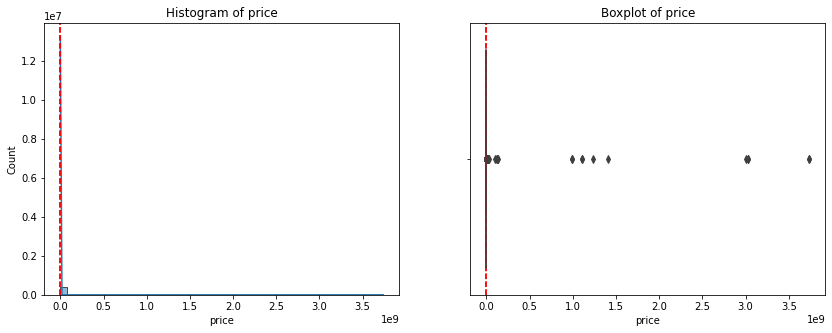

In [20]:
plot_outliers_iqr(df_cars, "price")

#### Year
* Year column still have many outliers in early years -> [1960;2022] arcording to above explaination

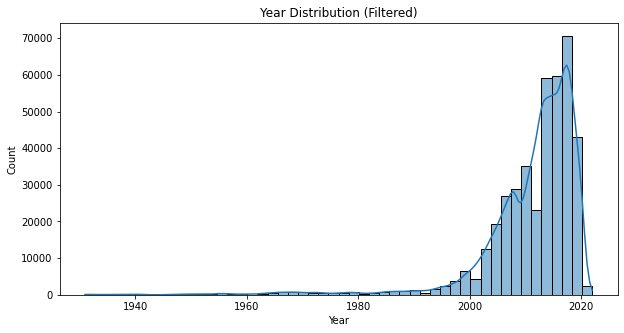

In [21]:
year_df = df_cars.select("year") \
    .where("year > 1930 AND year < 2023") \
    .toPandas()

plt.figure(figsize=(10,5))
sns.histplot(year_df["year"], bins=50, kde=True)
plt.title("Year Distribution (Filtered)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

Column: year
Q1=2008.00, Q3=2017.00, IQR=9.00
Lower bound=1994.50, Upper bound=2030.50
Outliers count=15417 / 413689


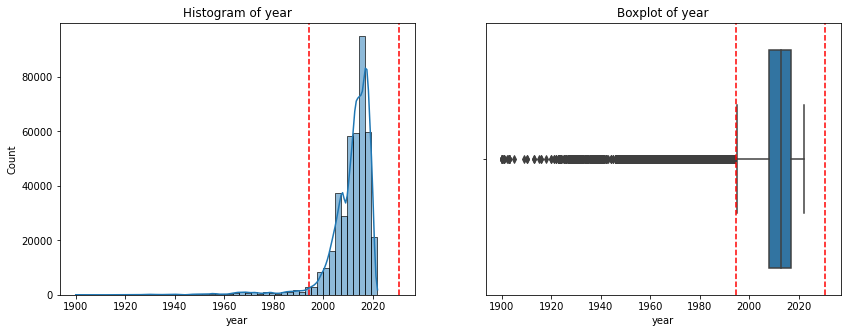

In [22]:
plot_outliers_iqr(df_cars, "year")

#### Odometer
* Odometer column still have many outliers arcording to IQR, might remove high-valid value -> Use quantile 0.99 for upper bound, and 0 for lower bound

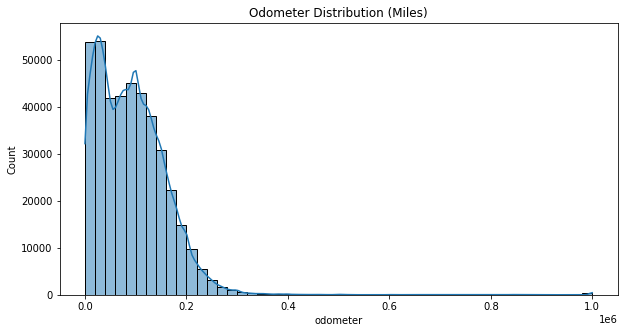

In [23]:
odo_df = df_cars.select("odometer").where("odometer BETWEEN 0 AND 1e6").toPandas()

plt.figure(figsize=(10,5))
sns.histplot(odo_df["odometer"], bins=50, kde=True)
plt.title("Odometer Distribution (Miles)")
plt.show()

Column: odometer
Q1=37725.00, Q3=133971.00, IQR=96246.00
Lower bound=-106644.00, Upper bound=278340.00
Outliers count=4202 / 410504


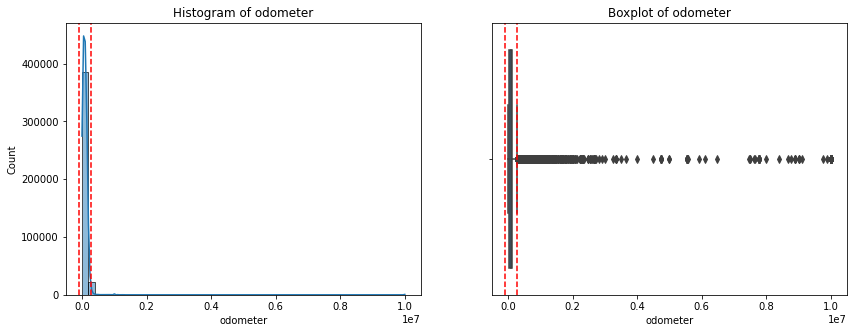

In [24]:
plot_outliers_iqr(df_cars, "odometer")

In [25]:
# --- Price (target) ---
price_q = df_cars.approxQuantile("price", [0.10, 0.99], 0.001)
price_lower, price_upper = 0, price_q[1]

df_cars = df_cars.filter((F.col("price") > price_lower) & (F.col("price") < price_upper))

# --- Year ---
year_lower, year_upper = 1959, 2023

# --- Odometer ---
odo_q = df_cars.approxQuantile("odometer", [0.10, 0.99], 0.001)
odo_lower, odo_upper = -1, odo_q[1]

df_cars = df_cars.withColumn(
    "year",
    F.when((F.col("year") > year_lower) & (F.col("year") < year_upper), F.col("year"))
     .otherwise(F.lit(None))
).withColumn(
    "odometer",
    F.when((F.col("odometer") > odo_lower) & (F.col("odometer") < odo_upper), F.col("odometer"))
     .otherwise(F.lit(None))
)

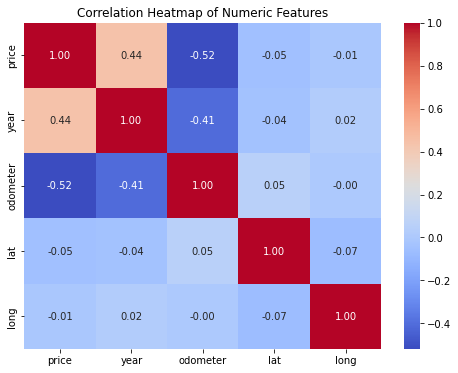

In [26]:
def plot_correlation_heatmap(df, numeric_cols):
    pdf = df.select(numeric_cols).toPandas()
    
    # Compute correlation
    corr = pdf.corr()
    
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
    plt.title("Correlation Heatmap of Numeric Features")
    plt.show()

numeric_cols = ["price", "year", "odometer", "lat", "long"]
plot_correlation_heatmap(df_cars, numeric_cols)

* Correlation increase from ~0.1 -> 0.4, 0.5 after remove outliers, duplicates and some null values
* Lat & Long would be used to extract more meaningful features

## Categorical features

In [27]:
def plot_categorical_distribution(df, col, rotate_xticks=True, top_n=10):
    freq_df = (
        df.groupBy(col)
          .agg(F.count("*").alias("count"))
          .orderBy(F.desc("count"))
    )
    
    pdf = freq_df.limit(top_n).toPandas()
    unique_count = df.select(col).agg(F.countDistinct(col)).collect()[0][0]
    
    # plot
    plt.figure(figsize=(10,5))
    sns.barplot(x=col, y="count", data=pdf, palette="viridis")
    
    title_suffix = f" (Top {top_n})" if unique_count > top_n else ""
    plt.title(f"Distribution of {col}{title_suffix} - {unique_count} unique")
    plt.ylabel("Count")
    plt.xlabel(col)
    
    if rotate_xticks:
        plt.xticks(rotation=45, ha="right")
    
    plt.show()


def plot_all_categoricals(df, cols, rotate_xticks=True, top_n=10):
    for col in cols:
        print(f"\nPlotting {col} ...")
        plot_categorical_distribution(df, col, rotate_xticks=rotate_xticks, top_n=top_n)


Plotting manufacturer ...


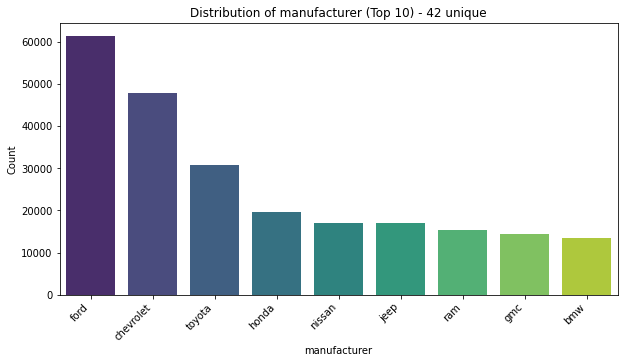


Plotting model ...


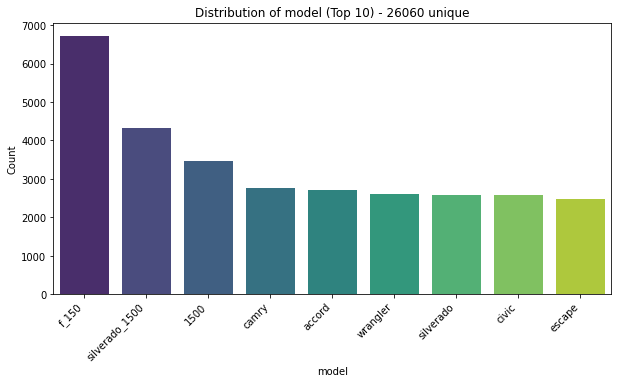


Plotting condition ...


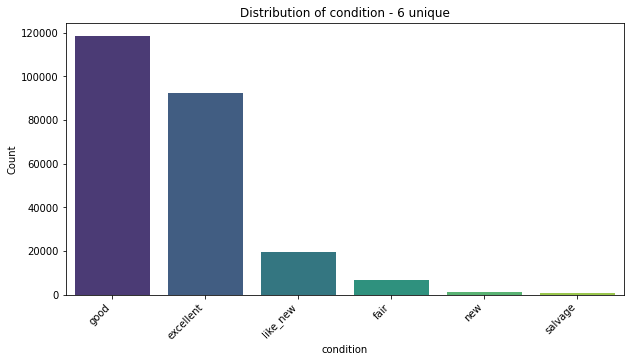


Plotting fuel ...


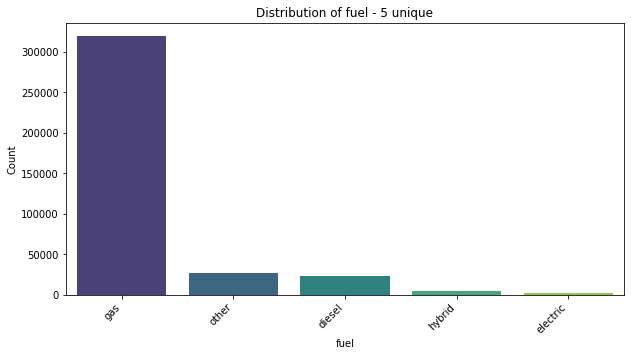


Plotting transmission ...


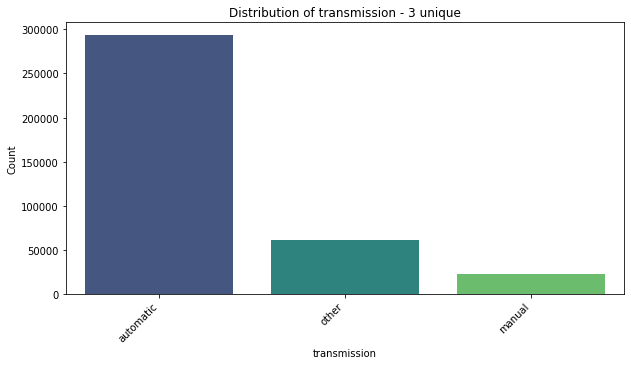


Plotting drive ...


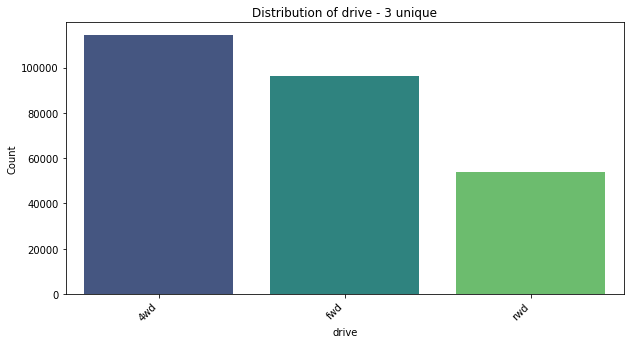


Plotting type ...


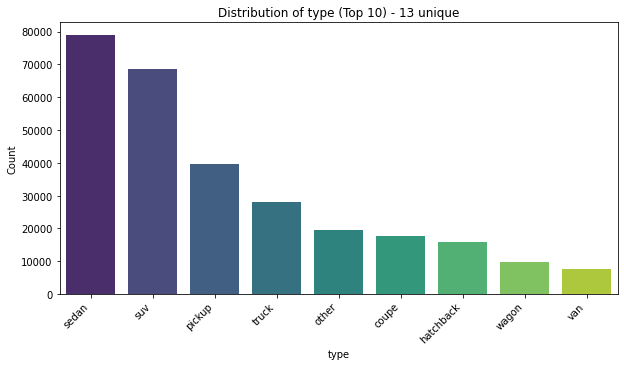


Plotting paint_color ...


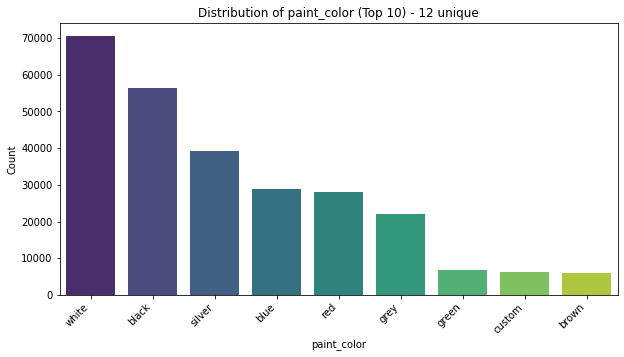


Plotting cylinders ...


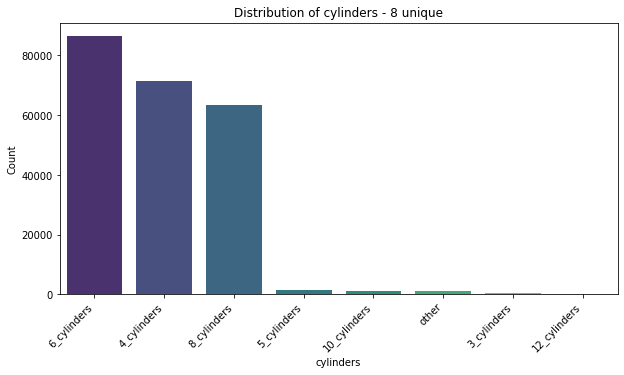

In [28]:
categorical_cols = [
    "manufacturer", "model", "condition", "fuel", "transmission", "drive",
    "type", "paint_color", "cylinders"
]

plot_all_categoricals(df_cars, categorical_cols)

In [ ]:
def plot_price_by_category_spark(df, cat_col, agg="median", top_n=10,
                                 sample_frac=0.02, max_sample=20000,
                                 random_state=42, log_scale=False):
    # 1. top-N categories (exclude null)
    top_rows = (
        df.filter(F.col(cat_col).isNotNull())
          .groupBy(cat_col)
          .count()
          .orderBy(F.desc("count"))
          .limit(top_n)
          .collect()
    )
    top_categories = [r[cat_col] for r in top_rows]

    if not top_categories:
        print(f"No non-null categories found for {cat_col}.")
        return

    # 2. Aggregation (median via percentile_approx, or mean)
    if agg == "median":
        agg_expr = F.expr("percentile_approx(price, 0.5)")
        agg_name = "price_median"
    else:
        agg_expr = F.avg("price")
        agg_name = "price_mean"

    agg_df = (
        df.filter(F.col(cat_col).isin(top_categories) & F.col("price").isNotNull())
          .groupBy(cat_col)
          .agg(agg_expr.alias(agg_name), F.count("*").alias("count"))
    )

    pdf_bar = agg_df.orderBy(F.desc(agg_name)).toPandas()

    # 3. Barplot (aggregated)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=agg_name, y=cat_col, data=pdf_bar, palette="viridis")
    plt.title(f"{agg.capitalize()} price by {cat_col} (Top {len(top_categories)})")
    plt.xlabel(agg.replace("_", " ").capitalize())
    plt.ylabel(cat_col)
    if log_scale:
        plt.xscale("log")
    plt.tight_layout()
    plt.show()

    # 4. Boxplot: sample the raw (category, price) pairs
    sample_df = (
        df.filter(F.col(cat_col).isin(top_categories) & F.col("price").isNotNull())
          .select(cat_col, "price")
          .sample(withReplacement=False, fraction=sample_frac, seed=random_state)
    )

    pdf_box = sample_df.toPandas()
    # cap sample size for safety
    if len(pdf_box) > max_sample:
        pdf_box = pdf_box.sample(n=max_sample, random_state=random_state)

    plt.figure(figsize=(12, 6))
    sns.boxplot(x="price", y=cat_col, data=pdf_box, order=pdf_bar[cat_col].tolist())
    plt.title(f"Price distribution by {cat_col} (sampled)")
    plt.xlabel("Price")
    plt.ylabel(cat_col)
    if log_scale:
        plt.xscale("log")
    plt.tight_layout()
    plt.show()

In [ ]:
cat_plot_configs = {
    "manufacturer": {"agg": "median", "top_n": 15, "log_scale": True},
    "model": {"agg": "median", "top_n": 10, "log_scale": True},
    "condition": {"agg": "median", "top_n": 10, "log_scale": False},
    "fuel": {"agg": "median", "top_n": 10, "log_scale": False},
    "transmission": {"agg": "median", "top_n": 5, "log_scale": False},
    "drive": {"agg": "median", "top_n": 5, "log_scale": False},
    "type": {"agg": "median", "top_n": 10, "log_scale": True},
    "paint_color": {"agg": "median", "top_n": 10, "log_scale": False},
    "cylinders": {"agg": "median", "top_n": 10, "log_scale": True},
}

for col, cfg in cat_plot_configs.items():
    print(f"\n=== {col.upper()} vs PRICE ===")
    plot_price_by_category_spark(
        df_cars,
        cat_col=col,
        agg=cfg["agg"],
        top_n=cfg["top_n"],
        log_scale=cfg["log_scale"]
    )

## Date / Time Features

In [ ]:
df_cars.select(
    F.min("posting_date").alias("min_date"),
    F.max("posting_date").alias("max_date"),
    F.countDistinct("posting_date").alias("unique_dates")
).show()

df_cars.select("posting_date").distinct().orderBy("posting_date").show(10, truncate=False)

In [ ]:
# Aggregate median price per month
trend_df = (
    df_cars.withColumn("posting_date_day", F.to_date("posting_date"))
           .filter(F.col("price").isNotNull())
           .groupBy("posting_date_day")
           .agg(F.expr("percentile_approx(price, 0.5)").alias("median_price"))
           .orderBy("posting_date_day")
           .toPandas()
)
# 5. Lineplot
plt.figure(figsize=(12,6))
sns.lineplot(x="posting_date_day", y="median_price", data=trend_df, marker="o")
plt.title("Median Car Price Trend Over Time")
plt.xlabel("posting_date_day")
plt.ylabel("Median Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Geographical features

In [ ]:
# Convert to Pandas for plotting
geo_df = df_cars.select("lat", "long").toPandas()

# Scatterplot
plt.figure(figsize=(10,6))
plt.scatter(geo_df["long"], geo_df["lat"], s=5, alpha=0.5)
plt.title("Car Listings Scatterplot (Lat vs Long)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
# Filter valid US coordinates (approximate)
df_us = df_cars.filter(
    ((F.col("lat").between(24, 50)) & (F.col("long").between(-125, -65)))
    | (F.col("lat").isNull() | F.col("long").isNull())
)

# Convert to Pandas for plotting
geo_df = df_us.select("lat", "long").toPandas()

# Scatterplot
plt.figure(figsize=(10,6))
plt.scatter(geo_df["long"], geo_df["lat"], s=5, alpha=0.5)
plt.title("Car Listings Scatterplot (Lat vs Long, US only)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
cond_us = (F.col("lat").between(24, 50)) & (F.col("long").between(-125, -65))

# Đếm trong US và ngoài US
count_us = df_cars.filter(cond_us).count()
count_out = df_cars.filter(~cond_us).count()
count_all = df_cars.count()

print("Total records:", count_all)
print("US records:", count_us, f"({count_us/count_all:.2%})")
print("Outside US records:", count_out, f"({count_out/count_all:.2%})")

* Outside US Records: too much small -> drop

In [ ]:
categorical_cols = [
    "state","region"
]

plot_all_categoricals(df_us, categorical_cols)

In [ ]:
cat_plot_configs = {
    "region": {"agg": "mean", "top_n": 10, "log_scale": True},
    "state": {"agg": "mean", "top_n": 10, "log_scale": True}
}

for col, cfg in cat_plot_configs.items():
    print(f"\n=== {col.upper()} vs PRICE ===")
    plot_price_by_category_spark(
        df_us,
        cat_col=col,
        agg=cfg["agg"],
        top_n=cfg["top_n"],
        log_scale=cfg["log_scale"]
    )

# 6. Preprocessing

## Imputer

In [ ]:
df_us = df_us.drop("VIN")
train_df, test_df = df_us.randomSplit([0.8, 0.2], seed=42)
print("Train count:", train_df.count())
print("Test count:", test_df.count())

### Categorical features

In [ ]:
def fill_mode_low_missing(df, cols):
    for col in cols:
        # Compute mode for the column
        row = df.groupBy(col).count().orderBy(F.desc("count")).first()
        if row:
            mode_val = row[0]
            # Replace nulls with mode
            df = df.withColumn(col, F.when(F.col(col).isNull(), mode_val).otherwise(F.col(col)))
            print(f"Filled '{col}' missing with mode: {mode_val}")
    return df


def fill_type_by_group(df, col="type", group_col="manufacturer"):
    # Ensure global_mode is scalar
    global_mode_row = df.groupBy(col).count().orderBy(F.desc("count")).first()
    global_mode = str(global_mode_row[0]) if global_mode_row else "Unknown"

    # Compute manufacturer-specific mode (skip nulls in type)
    manu_mode = (
        df.filter(F.col(col).isNotNull())
          .groupBy(group_col, col)
          .count()
          .withColumn("rn", F.row_number().over(
              Window.partitionBy(group_col).orderBy(F.desc("count"))
          ))
          .filter("rn = 1")
          .select(F.col(group_col), F.col(col).alias(f"{col}_mode"))
    )

    # Join and fill, fallback to global_mode
    df = (
        df.join(manu_mode, on=group_col, how="left")
          .withColumn(
              col,
              F.when(F.col(col).isNull(), F.coalesce(F.col(f"{col}_mode"), F.lit(global_mode)))
               .otherwise(F.col(col))
          )
          .drop(f"{col}_mode")
    )

    return df

In [ ]:
# -----------------------------
# Fill low-missing columns
# -----------------------------
low_missing_cols = ["manufacturer", "model", "transmission", "fuel","state"]

train_df = fill_mode_low_missing(train_df, low_missing_cols)
train_df = fill_type_by_group(train_df, col="type", group_col="manufacturer")

# -----------------------------
# Prepare mode dictionary from train data for test set
# -----------------------------
mode_dict = {}
for col in low_missing_cols:
    row = train_df.groupBy(col).count().orderBy(F.desc("count")).first()
    mode_dict[col] = row[0] if row else "Unknown"

# Apply modes to test data
for col, val in mode_dict.items():
    test_df = test_df.withColumn(col, F.when(F.col(col).isNull(), F.lit(val)).otherwise(F.col(col)))

# -----------------------------
# Fill 'type' in test using manufacturer + global mode
# -----------------------------
global_mode_type = train_df.groupBy("type").count().orderBy(F.desc("count")).first()[0]

manu_mode = (
    train_df.groupBy("manufacturer", "type")
            .count()
            .withColumn("rn", F.row_number().over(
                Window.partitionBy("manufacturer").orderBy(F.desc("count"))
            ))
            .filter("rn = 1")
            .select("manufacturer", F.col("type").alias("type_mode"))
)

test_df = (
    test_df.join(manu_mode, on="manufacturer", how="left")
           .withColumn(
               "type",
               F.coalesce(F.col("type"), F.col("type_mode"), F.lit(global_mode_type))
           )
           .drop("type_mode")
)

# -----------------------------
# Fill high-missing columns with 'Unknown'
# -----------------------------
high_missing_cols = ["cylinders", "condition", "drive", "paint_color"]

for col in high_missing_cols:
    train_df = train_df.withColumn(col, F.when(F.col(col).isNull(), "Unknown").otherwise(F.col(col)))
    test_df = test_df.withColumn(col, F.when(F.col(col).isNull(), "Unknown").otherwise(F.col(col)))

### Numerical feautures

In [ ]:
def get_median_dict(df, cols):
    median_dict = {}
    for col in cols:
        median_val = df.approxQuantile(col, [0.5], 0.001)[0]
        if median_val is not None:
            median_dict[col] = median_val
        else:
            median_dict[col] = None  # fallback if all nulls
    return median_dict


def fill_with_median(df, median_dict):
    for col, median_val in median_dict.items():
        if median_val is not None:
            df = df.withColumn(
                col,
                F.when(F.col(col).isNull(), F.lit(median_val)).otherwise(F.col(col))
            )
    return df

numeric_cols = ["odometer","year"]
median_dict = get_median_dict(train_df, numeric_cols)
print("Median dict:", median_dict)

train_df = fill_with_median(train_df, median_dict)
test_df  = fill_with_median(test_df, median_dict)

In [ ]:
def fill_time_forward_backward(df, col, new_col=None, group_col=None, order_col=None):
    if new_col is None:
        new_col = col
    
    # Window for forward fill
    w_f = Window.partitionBy(group_col).orderBy(order_col).rowsBetween(Window.unboundedPreceding, 0) \
        if group_col else Window.orderBy(order_col).rowsBetween(Window.unboundedPreceding, 0)
    
    # Forward fill
    df = df.withColumn(f"{new_col}_ffill", F.last(col, ignorenulls=True).over(w_f))
    
    # Window for backward fill
    w_b = Window.partitionBy(group_col).orderBy(order_col).rowsBetween(0, Window.unboundedFollowing) \
        if group_col else Window.orderBy(order_col).rowsBetween(0, Window.unboundedFollowing)
    
    # Backward fill
    df = df.withColumn(f"{new_col}_bfill", F.first(f"{new_col}_ffill", ignorenulls=True).over(w_b))
    
    # Rename final column
    df = df.withColumn(new_col, F.col(f"{new_col}_bfill")) \
           .drop(f"{new_col}_ffill").drop(f"{new_col}_bfill")
    
    return df

In [ ]:
train_df = fill_time_forward_backward(
    train_df,
    col="posting_date",
    new_col="posting_date_filled",
    group_col="manufacturer",
    order_col="id"
)
test_df = fill_time_forward_backward(
    test_df,
    col="posting_date",
    new_col="posting_date_filled",
    group_col="manufacturer",
    order_col="id"
)


In [ ]:
def fill_latlong_by_state_mode(df, lat_col="lat", long_col="long", state_col="state"):
    # Compute mode per state for lat
    lat_mode = (
        df.groupBy(state_col, lat_col)
          .count()
          .withColumn("rn", F.row_number().over(
              Window.partitionBy(state_col).orderBy(F.desc("count"))
          ))
          .filter("rn = 1")
          .select(F.col(state_col), F.col(lat_col).alias("lat_mode"))
    )
    
    # Compute mode per state for long
    long_mode = (
        df.groupBy(state_col, long_col)
          .count()
          .withColumn("rn", F.row_number().over(
              Window.partitionBy(state_col).orderBy(F.desc("count"))
          ))
          .filter("rn = 1")
          .select(F.col(state_col), F.col(long_col).alias("long_mode"))
    )
    
    # Join mode values
    df = df.join(lat_mode, on=state_col, how="left") \
           .join(long_mode, on=state_col, how="left")
    
    # Fill: nếu lat hoặc long null → ghi đè cả 2 bằng mode
    df = df.withColumn(
        lat_col,
        F.when(F.col(lat_col).isNull() | F.col(long_col).isNull(),
               F.col("lat_mode")).otherwise(F.col(lat_col))
    ).withColumn(
        long_col,
        F.when(F.col(lat_col).isNull() | F.col(long_col).isNull(),
               F.col("long_mode")).otherwise(F.col(long_col))
    ).drop("lat_mode").drop("long_mode")
    
    return df

train_df = fill_latlong_by_state_mode(train_df, lat_col="lat", long_col="long", state_col="state")
test_df = fill_latlong_by_state_mode(test_df, lat_col="lat", long_col="long", state_col="state")

In [ ]:
train_df = (
    train_df
    .drop("posting_date", "id")                      
    .withColumnRenamed("posting_date_filled", "posting_date") 
)
test_df = (
    test_df
    .drop("posting_date", "id")                   
    .withColumnRenamed("posting_date_filled", "posting_date")  
)
test_df

In [ ]:
missing_df = plot_missing_values_spark(test_df)
missing_df

## Feature Engineering 0 chắc

In [ ]:
# def add_numerical_features(df):
#     df = df.withColumn("age", F.year("posting_date") - F.col("year"))
#     df = df.withColumn("log_price", F.log1p(F.col("price")))
#     df = df.withColumn("log_odometer", F.log1p(F.col("odometer")))
#     df = df.withColumn("km_per_year", F.col("odometer") / (F.col("age")+1))
#     return df

# train_df = add_numerical_features(train_df)
# test_df  = add_numerical_features(test_df)

In [ ]:
# def add_encoding(train_df, test_df, target_col="price"):
#     # --- Ordinal encoding condition ---
#     condition_order = {
#         "new": 5,
#         "like new": 4,
#         "excellent": 3,
#         "good": 2,
#         "fair": 1,
#         "salvage": 0
#     }
#     mapping_expr = F.create_map([F.lit(x) for kv in condition_order.items() for x in kv])
#     train_df = train_df.withColumn("condition_encoded", mapping_expr[F.col("condition")])
#     test_df  = test_df.withColumn("condition_encoded", mapping_expr[F.col("condition")])
    
#     # --- One-hot encoding ---
#     onehot_cols = ["fuel", "transmission", "drive", "type", "paint_color"]
#     for col in onehot_cols:
#         # Fit StringIndexer trên train
#         indexer = StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep").fit(train_df)
#         train_df = indexer.transform(train_df)
#         test_df  = indexer.transform(test_df)
        
#         # Fit OneHotEncoder trên train_indexed
#         encoder = OneHotEncoder(inputCols=[col+"_index"], outputCols=[col+"_ohe"])
#         encoder_model = encoder.fit(train_df)
#         train_df = encoder_model.transform(train_df)
#         test_df  = encoder_model.transform(test_df)

#     # --- Target encoding (median) ---
#     for col in ["manufacturer", "state"]:
#         median_df = train_df.groupBy(col).agg(F.expr(f"percentile_approx({target_col}, 0.5)").alias(f"median_price_by_{col}"))
#         train_df = train_df.join(median_df, on=col, how="left")
#         global_median = train_df.agg(F.expr(f"percentile_approx({target_col}, 0.5)")).first()[0]
#         test_df  = test_df.join(median_df, on=col, how="left").fillna(global_median)

#     # --- Frequency encoding ---
#     total_count = train_df.count()
#     for col in ["region", "model"]:
#         freq_df = train_df.groupBy(col).count().withColumn("freq_" + col, F.col("count") / total_count).select(col, "freq_" + col)
#         train_df = train_df.join(freq_df, on=col, how="left")
#         test_df  = test_df.join(freq_df, on=col, how="left").fillna(0)
    
#     # --- Drop original categorical columns ---
#     drop_cols = ["condition"] + onehot_cols + ["manufacturer", "state", "region", "model"]
#     train_df = train_df.drop(*drop_cols)
#     test_df  = test_df.drop(*drop_cols)
    
#     return train_df, test_df

# train_df, test_df = add_encoding(train_df, test_df, target_col="price")

In [ ]:
# def add_geo_cluster_features(train_df, test_df, lat_col="lat", long_col="long", target_col="price", k=10, seed=42):
#     assembler = VectorAssembler(inputCols=[lat_col, long_col], outputCol="features")
#     train_df = assembler.transform(train_df)
#     test_df  = assembler.transform(test_df)

#     # Fit KMeans trên train không null
#     kmeans_model = KMeans(k=k, seed=seed, featuresCol="features", predictionCol="geo_cluster") \
#                    .fit(train_df.dropna(subset=[lat_col, long_col, target_col]))

#     train_clustered = kmeans_model.transform(train_df).cache()
#     test_clustered  = kmeans_model.transform(test_df)

#     # Median price per cluster
#     cluster_median_df = (
#         train_clustered.groupBy("geo_cluster")
#                        .agg(F.expr(f"percentile_approx({target_col},0.5,0.01)").alias("median_price_by_geo"))
#     )

#     global_median = train_clustered.agg(F.expr(f"percentile_approx({target_col},0.5,0.01)").alias("global_median")).first()[0]

#     train_final = train_clustered.join(cluster_median_df, on="geo_cluster", how="left")
#     test_final  = test_clustered.join(cluster_median_df, on="geo_cluster", how="left").fillna({"median_price_by_geo": global_median})

#     train_final = train_final.drop("features")
#     test_final  = test_final.drop("features")

#     return train_final, test_final
# train_df, test_df = add_geo_cluster_features(train_df, test_df)

# 7. Training

In [ ]:
# train_df

In [ ]:
# drop_cols = [c for c in train_df.columns if c.endswith("_index")]
# train_df = train_df.drop(*drop_cols)
# test_df = test_df.drop(*drop_cols)

In [ ]:
# def corr(df, target_col="log_price"):
#     # Identify numeric columns (exclude target)
#     numeric_cols = [c for c, t in df.dtypes if t in ("int", "double") and c != target_col]
    
#     # Assemble numeric cols + target for correlation
#     numeric_cols_for_corr = numeric_cols + [target_col]
#     assembler_corr = VectorAssembler(inputCols=numeric_cols_for_corr, outputCol="features_corr")
#     df_corr_vec = assembler_corr.transform(df).select("features_corr")
    
#     # Compute correlation matrix
#     corr_matrix = Correlation.corr(df_corr_vec, "features_corr", "pearson").head()[0].toArray()
#     corr_df = pd.DataFrame(corr_matrix, index=numeric_cols_for_corr, columns=numeric_cols_for_corr)
    
#     return corr_d

In [ ]:
# corr_df = corr(train_df, target_col="log_price")
# plt.figure(figsize=(10,8))
# sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm")
# plt.title("Correlation Matrix")
# plt.show()

In [ ]:
# cols = df_cars.columns
# cols.remove('id')
# cols.remove('price')

# assembler = VectorAssembler(inputCols=cols, outputCol='features')

# df_cars = assembler.transform(df_cars)

In [ ]:
# df_data = df_cars.select(F.col('features'), F.col('price').alias('label'))

In [ ]:
# classifier = RandomForestRegressor(featuresCol='features', labelCol='label')
# evaluator = RegressionEvaluator()
# grid = ParamGridBuilder().build()
# cv = CrossValidator(estimator=classifier, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)

# cv_model = cv.fit(df_train)

# 14. Evaluation

In [ ]:
# cv_model.avgMetrics

In [ ]:
# df_test = cv_model.bestModel.transform(df_test)

In [ ]:
# df_test.show(5)

In [ ]:
# RegressionEvaluator(predictionCol='prediction', labelCol='label').evaluate(df_test)

# 15. Single Sample Prediction

In [ ]:
# X_test, y_test = df_test.head().features, df_test.head().label
# y_pred = cv_model.bestModel.predict(X_test)

# print(f'prediction: {y_pred}, ground truth: {y_test}')